In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import furniture_bench

import os
import pickle
import numpy as np
from pathlib import Path

from src.visualization.render_mp4 import (
    data_to_video,
    unpickle_data,
    create_mp4_jupyter,
    mp4_from_pickle_jupyter,
)
from src.gym import get_env

from tqdm import tqdm

In [3]:
os.environ["DATA_DIR_RAW"] = "/data/scratch-oc40/pulkitag/ankile/furniture-data/"

In [4]:
teleopdir = Path(os.environ["DATA_DIR_RAW"]) / "raw" / "sim" / "teleop"

In [5]:
pickles = list(teleopdir.rglob("*success.pkl"))

len(pickles)

60

In [12]:
tmp_rollout_dir = Path(".") / "tmp_rollout_dir"
tmp_rollout_dir.mkdir(exist_ok=True)

In [13]:
total = 0

for i, p in enumerate(pickles):
    data = unpickle_data(p)
    if not data["success"]:
        continue
    ims = data_to_video(data)
    video_tag = create_mp4_jupyter(ims, tmp_rollout_dir / f"video{i}.mp4")
    display(video_tag)
    total += 1

print(f"Total successes: {total}")

File saved as tmp_rollout_dir/video0.mp4


File saved as tmp_rollout_dir/video1.mp4


File saved as tmp_rollout_dir/video2.mp4


File saved as tmp_rollout_dir/video3.mp4


File saved as tmp_rollout_dir/video4.mp4


File saved as tmp_rollout_dir/video5.mp4


File saved as tmp_rollout_dir/video6.mp4


File saved as tmp_rollout_dir/video7.mp4


File saved as tmp_rollout_dir/video8.mp4


File saved as tmp_rollout_dir/video9.mp4


File saved as tmp_rollout_dir/video10.mp4


KeyboardInterrupt: 

## Play back teleop demos in the sim

### Teleop demo

In [12]:
data = unpickle_data(
    "/data/scratch/ankile/furniture-diffusion/data/raw/sim/one_leg/low/2024-01-18-14:40:50/2024-01-18-14:40:50.pkl"
)
data = unpickle_data(
    "/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/scripted/one_leg/low/2024-01-12-16:21:52/2024-01-12-16:21:52_success.pkl"
)

lamp = unpickle_data(
    "/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/lamp/low/2024-01-18-15:00:10/2024-01-18-15:00:10.pkl"
)

data["observations"][0].keys()

dict_keys(['color_image1', 'color_image2', 'robot_state', 'parts_poses'])

In [6]:
env = get_env(
    gpu_id=0,
    # obs_type="image",
    furniture="lamp",
    num_envs=1,
    randomness="low",
    resize_img=True,
    act_rot_repr="quat",
    ctrl_mode="diffik",
    verbose=False,
)

PyTorch version 2.0.1+cu117
Device count 2
/data/scratch/ankile/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /data/scratch/ankile/.cache as PyTorch extensions root...
Emitting ninja build file /data/scratch/ankile/.cache/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module gymtorch...


In [9]:
def play_back_trajectory(actions, env, filename):
    imgs1, imgs2 = [], []

    obs = env.reset()
    imgs1.append(obs["color_image1"])
    imgs2.append(obs["color_image2"])

    for action in tqdm(actions):
        obs, _, _, _ = env.step(action)
        imgs1.append(obs["color_image1"])
        imgs2.append(obs["color_image2"])

    imgs1 = np.array([img.cpu().numpy() for img in imgs1])
    imgs2 = np.array([img.cpu().numpy() for img in imgs2])

    imgs1 = imgs1.reshape(-1, 224, 224, 3)
    imgs2 = imgs2.reshape(-1, 224, 224, 3)

    imgs1.shape, imgs2.shape
    images = np.concatenate([imgs1, imgs2], axis=2)

    video_tag = create_mp4_jupyter(images, tmp_rollout_dir / filename)
    display(video_tag)

In [13]:
play_back_trajectory(lamp["actions"], env, "scripted_demo_lamp_1.mp4")

INFO: Found collision-free init pose
 92%|█████████▏| 645/701 [00:45<00:06,  8.93it/s]

In [21]:
data1 = unpickle_data(
    "/data/scratch/ankile/furniture-diffusion/data/raw/sim/one_leg/low/2024-01-18-14:40:50/2024-01-18-14:40:50.pkl"
)

ims1 = data_to_video(lamp)

video_tag = create_mp4_jupyter(ims1, tmp_rollout_dir / "test_lamp.mp4")
display(video_tag)

FileNotFoundError: [Errno 2] No such file or directory: '/data/scratch/ankile/furniture-diffusion/data/raw/sim/one_leg/low/2024-01-18-14:40:50/2024-01-18-14:40:50.pkl'

### Scripted demo

In [9]:
import zarr

z = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/image/lamp/data_batch_32.zarr"
)

In [22]:
ep_num = 3

start_idx = z["episode_ends"][ep_num - 1]
end_idx = z["episode_ends"][ep_num]

actions = z["action"][start_idx:end_idx]

actions.shape

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


(643, 8)

In [23]:
play_back_trajectory(actions, env, "scripted_demo_1.mp4")

INFO: Found collision-free init pose
100%|██████████| 643/643 [00:55<00:00, 11.54it/s]


File saved as tmp_rollout_dir/scripted_demo_1.mp4


In [2]:
import numpy as np
from tqdm import tqdm
import zarr
import random

In [3]:
chunk_size = (1_000, 224, 224, 3)  # Adjust based on your needs

In [4]:
tmp = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/image/one_leg/data_batch_32.zarr",
    mode="r",
)

tmp["color_image1"].shape, tmp["color_image2"].shape

((248613, 224, 224, 3), (248613, 224, 224, 3))

In [5]:
np_img1 = np.zeros(tmp["color_image1"].shape, dtype=np.uint8)

for i in tqdm(range(0, tmp["color_image1"].shape[0], 1024)):
    np_img1[i : i + 1024] = tmp["color_image1"][i : i + 1024]

100%|██████████| 243/243 [00:40<00:00,  6.01it/s]


In [6]:
np_img2 = np.zeros(tmp["color_image2"].shape, dtype=np.uint8)

for i in tqdm(range(0, tmp["color_image2"].shape[0], 1024)):
    np_img2[i : i + 1024] = tmp["color_image2"][i : i + 1024]

100%|██████████| 243/243 [02:15<00:00,  1.79it/s]


In [7]:
np_img1.shape, np_img2.shape

((248613, 224, 224, 3), (248613, 224, 224, 3))

In [5]:
np_img1.shape, np_img2.shape

((369535, 224, 224, 3), (369535, 224, 224, 3))

In [7]:
# Create a directory store
store = zarr.DirectoryStore("stores/directory_store.zarr")

# Define chunk size
chunk_size = (1_000, 224, 224, 3)  # Adjust based on your needs

# Create Zarr arrays
color_image1 = zarr.create(
    shape=np_img1.shape,
    chunks=chunk_size,
    dtype=np_img1.dtype,
    store=store,
    path="color_image1",
    overwrite=True,
)
color_image2 = zarr.create(
    shape=np_img2.shape,
    chunks=chunk_size,
    dtype=np_img2.dtype,
    store=store,
    path="color_image2",
    overwrite=True,
)

# Populate the arrays
color_image1[:] = np_img1
color_image2[:] = np_img2

In [2]:
# Create a directory store
store = zarr.DirectoryStore("stores/directory_store.zarr")

# Now wrap the store with LRU cache
cached_store = zarr.LRUStoreCache(store, max_size=None)

# Access the arrays using the cached store for later operations
color_image1 = zarr.open_array(cached_store, path="color_image1", mode="r")
color_image2 = zarr.open_array(cached_store, path="color_image2", mode="r")

In [3]:
color_image1

<zarr.core.Array '/color_image1' (369535, 224, 224, 3) uint8 read-only>

In [5]:
for i in tqdm(range(1_000)):
    # Get just random chunks of 16 images
    random_idx = random.randint(0, color_image1.shape[0] - 16)
    color_image1[i : i + 16]
    color_image2[i : i + 16]

100%|██████████| 1000/1000 [00:47<00:00, 21.10it/s]


In [6]:
# iterate over the arrays to test the cache
for i in tqdm(range(0, color_image1.shape[0], 1024)):
    color_image1[i : i + 1024]
    color_image2[i : i + 1024]

100%|██████████| 361/361 [01:08<00:00,  5.24it/s]


In [7]:
# This time, hope it's much faster
for i in tqdm(range(1_000)):
    random_idx = random.randint(0, color_image1.shape[0] - 16)
    color_image1[i : i + 16]
    color_image2[i : i + 16]

100%|██████████| 1000/1000 [00:41<00:00, 24.06it/s]


In [6]:
# Create a ZipStore
zip_store = zarr.ZipStore("stores/zip_store.zip", mode="w")

# Define chunk size

# Create Zarr arrays within the ZipStore
color_image1 = zarr.create(
    shape=np_img1.shape,
    chunks=chunk_size,
    dtype=np_img1.dtype,
    store=zip_store,
    path="color_image1",
)
color_image2 = zarr.create(
    shape=np_img2.shape,
    chunks=chunk_size,
    dtype=np_img2.dtype,
    store=zip_store,
    path="color_image2",
)

# Populate the arrays
color_image1[:] = np_img1
color_image2[:] = np_img2

# It's important to close the ZipStore
zip_store.close()

In [1]:
import zarr
import numpy as np
from concurrent.futures import ThreadPoolExecutor


def load_chunk(arr, chunk_slice):
    return arr[chunk_slice]


# Function to get all chunk slices for a given Zarr array
def get_chunk_slices(shape, chunks):
    ranges = [range(0, s, c) for s, c in zip(shape, chunks)]
    return [
        tuple(slice(i, min(i + c, s)) for i, c, s in zip(start, chunks, shape))
        for start in np.ndindex(*map(len, ranges))
    ]


# Open the ZipStore in read-only mode
zip_store = zarr.ZipStore("stores/zip_store.zip", mode="r")

# Open the arrays
color_image1 = zarr.open_array(store=zip_store, path="color_image1", mode="r")
color_image2 = zarr.open_array(store=zip_store, path="color_image2", mode="r")

# Get the chunk slices for each array
chunk_slices1 = get_chunk_slices(color_image1.shape, color_image1.chunks)
chunk_slices2 = get_chunk_slices(color_image2.shape, color_image2.chunks)

# Create empty arrays to hold the data in memory
color_image1_data = np.empty(color_image1.shape, dtype=color_image1.dtype)
color_image2_data = np.empty(color_image2.shape, dtype=color_image2.dtype)

# Load data in parallel
with ThreadPoolExecutor() as executor:
    # Load color_image1
    futures1 = [executor.submit(load_chunk, color_image1, cs) for cs in chunk_slices1]
    for cs, future in enumerate(futures1):
        color_image1_data[chunk_slices1[cs]] = future.result()

    # Load color_image2
    futures2 = [executor.submit(load_chunk, color_image2, cs) for cs in chunk_slices2]
    for cs, future in enumerate(futures2):
        color_image2_data[chunk_slices2[cs]] = future.result()

# Close the store when done
zip_store.close()

In [8]:
np_img1.shape, np_img2.shape

((248613, 224, 224, 3), (248613, 224, 224, 3))

In [9]:
from numcodecs import Blosc


compressor = Blosc(cname="zstd", clevel=9, shuffle=Blosc.BITSHUFFLE)

# Create a directory store or ZipStore
store = zarr.DirectoryStore("stores/directory_store_2.zarr")
# Or for ZipStore: store = zarr.ZipStore('path/to/zip_store.zip')

# Create Zarr arrays with the compressor
color_image1 = zarr.array(
    np_img1,
    chunks=chunk_size,
    compressor=compressor,
    store=store,
    path="color_image1",
)
color_image2 = zarr.array(
    np_img1,
    chunks=chunk_size,
    compressor=compressor,
    store=store,
    path="color_image2",
)

KeyboardInterrupt: 

In [4]:
# Open the DirectoryStore in read-only mode
store = zarr.DirectoryStore("stores/directory_store_2.zarr")

# Open the arrays
color_image1 = zarr.open_array(store=store, path="color_image1", mode="r")
color_image2 = zarr.open_array(store=store, path="color_image2", mode="r")

In [ ]:
color_image1.shape, color_image2.shape

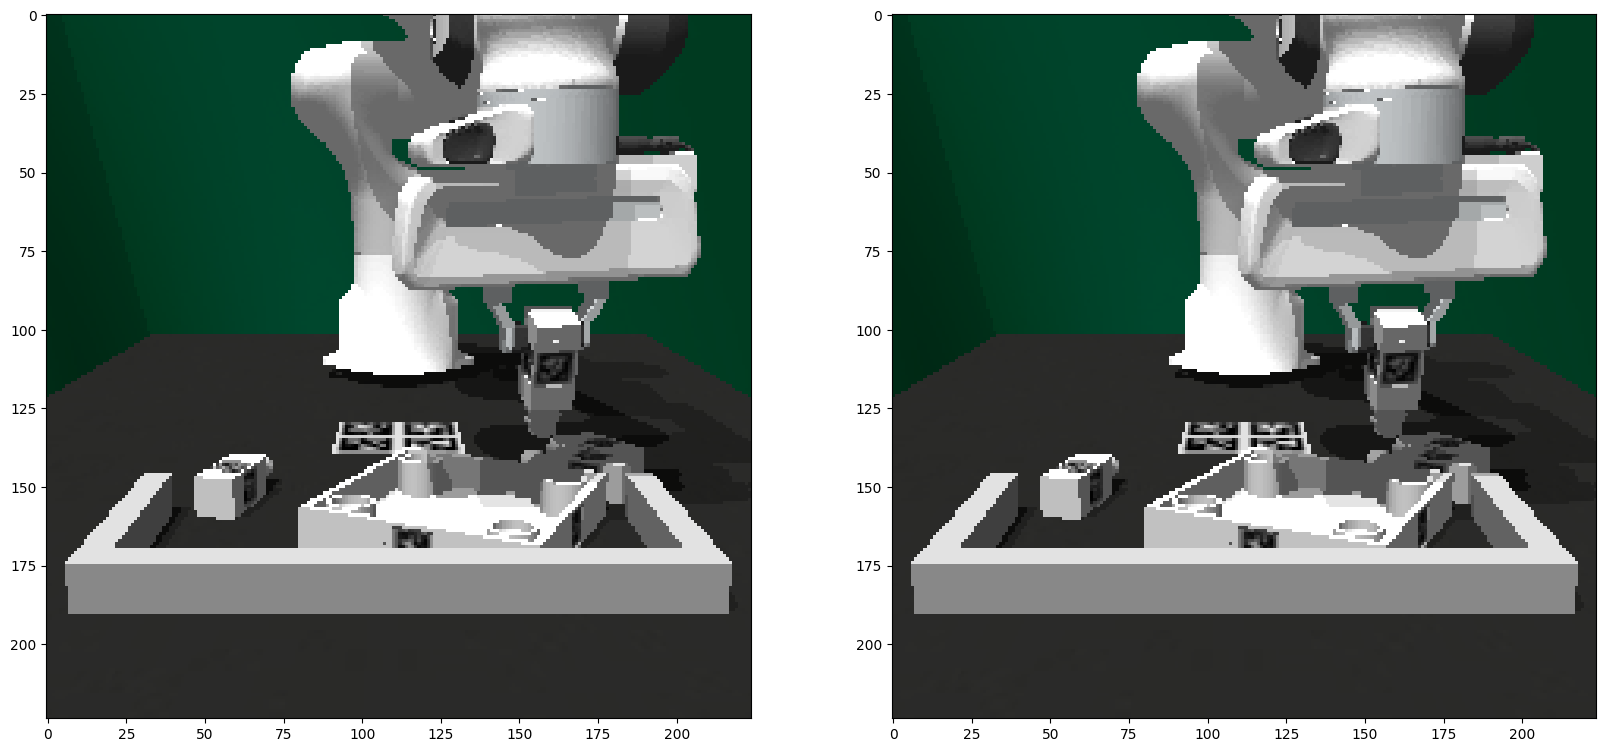

In [12]:
# Show an image
import matplotlib.pyplot as plt

img_idx = 190

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(color_image2[img_idx])
ax2.imshow(tmp["color_image2"][img_idx])

In [13]:
tmp1 = color_image1[:]
tmp2 = color_image2[:]

In [14]:
tmp1.shape, tmp2.shape

((369535, 224, 224, 3), (369535, 224, 224, 3))

In [17]:
type(tmp1)

numpy.ndarray

In [21]:
for i in tqdm(range(1_000)):
    random_idx = random.randint(0, tmp1.shape[0] - 16)
    color_image2[i : i + 16]

100%|██████████| 1000/1000 [00:39<00:00, 25.21it/s]


In [16]:
import zarr

z = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/image/one_leg/scripted.zarr",
    mode="r",
)

In [6]:
z["color_image1"].shape, z["color_image2"].shape

((4005, 224, 224, 3), (4005, 224, 224, 3))

In [7]:
z["episode_ends"][:]

array([   0,  486,  962, 1453, 1915, 2432, 2911, 3486, 4005], dtype=uint32)

## Look at MP4 compression rate

In [12]:
# Make 1280 by 720 videos of length 1_000
vid1280 = np.zeros((1_000, 720, 1280, 3), dtype=np.uint8)
vid1280[:, :180, :320, :] = np.random.randint(
    0, 255, size=(1_000, 180, 320, 3), dtype=np.uint8
)
# vid240 = np.random.randint(0, 255, size=(1_000, 240, 240, 3), dtype=np.uint8)

In [13]:
with open("test_1280.npy", "wb") as f:
    pickle.dump(vid1280, f)

In [9]:
# 1000 * 720 * 1280 * 3 / 1e9
1000 * 240 * 240 * 3 / 1e9

0.1728

In [14]:
# Write it as an mp4
create_mp4_jupyter(vid1280, "test_1280.mp4")

File saved as test_1280.mp4


In [1]:
import gzip
import numpy
import bz2
import lzma
import pickle

from src.visualization.render_mp4 import unpickle_data

In [3]:
data1 = unpickle_data(
    "/data/scratch/ankile/furniture-data/raw-old/sim/scripted/image/one_leg/low/2023-10-25-17:49:38/2023-10-25-17:49:38.pkl"
)

In [4]:
%%timeit
with open("no_compression.pickle", "wb") as f:
    pickle.dump(data1, f)


1.28 s ± 26.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit
# Read them all back and verify they are the same
with open("no_compression.pickle", "rb") as f:
    data1 = pickle.load(f)

82 ms ± 8.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
with gzip.open("gzip_test.gz", "wb") as f:
    pickle.dump(data1, f)


10 s ± 68.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
with gzip.open("gzip_test.gz", "rb") as f:
    data2 = pickle.load(f)


305 ms ± 8.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
with bz2.BZ2File("bz2_test.pbz2", "wb") as f:
    pickle.dump(data1, f)


23.3 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
with bz2.BZ2File("bz2_test.pbz2", "rb") as f:
    data3 = pickle.load(f)


1.53 s ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
with lzma.open("lzma_test.xz", "wb") as f:
    pickle.dump(data1, f)

19.8 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
with lzma.open("lzma_test.xz", "rb") as f:
    data4 = pickle.load(f)


352 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
data1.keys()  # , data2.keys(), data3.keys(), data4.keys()

dict_keys(['observations', 'actions', 'rewards', 'skills', 'success', 'furniture', 'error', 'error_description'])

In [22]:
data1["observations"][0].keys(), data1["observations"][0]["image_size"]

(dict_keys(['color_image1', 'color_image2', 'image_size', 'robot_state']),
 (224, 224))

In [ ]:
# Check the first frame of the video
(
    np.all(
        data1["observations"][0]["color_image1"]
        == data2["observations"][0]["color_image1"]
    ),
    np.all(
        data1["observations"][0]["color_image1"]
        == data3["observations"][0]["color_image1"]
    ),
    np.all(
        data1["observations"][0]["color_image1"]
        == data4["observations"][0]["color_image1"]
    ),
)

(True, True, True)

## Inspect the teleop demos that are continued from one_leg scripted

In [13]:
import zarr
import numpy as np
from pathlib import Path
from src.visualization.render_mp4 import mp4_from_pickle_jupyter, unpickle_data

tmp_rollout_dir = Path(".") / "tmp_rollout_dir"

In [10]:
demos = list(
    Path(
        "/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/square_table/teleop"
    ).rglob("**/success/*.pkl")
)

len(demos)

5

In [11]:
# Look at them
for d in demos:
    mp4_from_pickle_jupyter(d, tmp_rollout_dir / f"{d.stem}.mp4", fps=20)

File saved as tmp_rollout_dir/2024-01-23T14:58:35.mp4


File saved as tmp_rollout_dir/2024-01-23T14:54:21.mp4


File saved as tmp_rollout_dir/2024-01-23T15:00:21.mp4


File saved as tmp_rollout_dir/2024-01-23T14:52:24.mp4


File saved as tmp_rollout_dir/2024-01-23T14:47:44.mp4


In [14]:
data = unpickle_data(demos[0])

In [16]:
for o in data["observations"]:
    print(o["robot_state"])

{'ee_pos': array([0.5672798 , 0.05542726, 0.12392187], dtype=float32), 'ee_quat': array([ 0.893298  ,  0.44938526, -0.00800878,  0.00271298], dtype=float32), 'ee_pos_vel': array([0., 0., 0.], dtype=float32), 'ee_ori_vel': array([0., 0., 0.], dtype=float32), 'gripper_width': array(0.065, dtype=float32), 'joint_positions': array([-0.02627765,  0.37315664,  0.12484822, -2.1427183 , -0.0946798 ,
        2.4966636 ,  0.00783486], dtype=float32), 'joint_velocities': array([ 1.6664130e-03, -1.1778297e-01,  4.5535173e-05, -1.9043961e-01,
       -9.0009038e-04,  8.6578093e-06, -4.7757021e-01], dtype=float32), 'joint_torques': array([ -1.1327953 ,  -1.1043097 ,  -0.7273272 ,   2.1952655 ,
         0.62520146,  -0.03687967,   0.21614273, -13.02217   ,
       -12.977918  ], dtype=float32)}
{'ee_pos': array([0.56581324, 0.05530322, 0.12382197], dtype=float32), 'ee_quat': array([ 0.8905997 ,  0.4546951 , -0.0088102 ,  0.00263281], dtype=float32), 'ee_pos_vel': array([-0.0656016 , -0.00458525, -0.005